In this Notebook, we'll explore data from Lyft that was provided in the "3d-object-detection-for-autonomous-vehicles" (https://www.kaggle.com/competitions/3d-object-detection-for-autonomous-vehicles/overview) Kaggle competition. Of the two data modalities provided (imagery and lidar point clouds), we will only be using imagery. Our goal is to explore i. Image classification and ii. Object Detection. While I could have chosen data from an origin that had exactly these tasks in mind (MNIST, CIFAR etc), I thought it would make the exploration more difficult and realistic by taking data not already tailored to the use case. 

After some general preprocessing work, we will split our exploration into two phases: Phase 1 will be Image Classification and Phase 2 Will be Object Detection. Within each phase, we will do additional preprocessing steps that are required for the task, and will further break up the phases into sections where we will use pretrained models imported from Pytorch and then try our hand at creating a more simplistic corresponding model by hand.

# Imports and inital data read.

In [3]:
import ast
from collections import Counter
import json
import os
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
import random
import re
import time
import plotly.express as px
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
from torchvision import models, ops
from torchvision.models.resnet import ResNet50_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Load the SDK
from lyft_dataset_sdk.lyftdataset import LyftDataset

In [4]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

# With our Data Processing finished, we now shift to create and train our models.

In [5]:
data_path = Path(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train")
json_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\data"
lyftdata = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 9.8 seconds.
Reverse indexing ...
Done reverse indexing in 2.8 seconds.


# Define our custom Dataset classes for image classification and object detection.

In [6]:
class Lyft_image_classification_CustomDataset(Dataset):
    def __init__(self, cropped_images_dir, target_category_name, required_size=224):
        self.cropped_images_dir = cropped_images_dir
        self.required_size = required_size
        self.image_filenames = os.listdir(cropped_images_dir)
        self.data = []
        #Our class will ingest cropped images from all categories. We must add corresponding labels to these images.
        #The images are stored in directories wrt their category. So, we use the dir name to label the image.
        #Iterate over each subdirectory in the main directory
        for category_folder in os.listdir(cropped_images_dir):
            category_dir = os.path.join(cropped_images_dir, category_folder)
            if os.path.isdir(category_dir):  # Check if it's a directory
                category_name = category_folder.split("_")[0]
                is_target_category = category_name == target_category_name
                label = 1 if is_target_category else 0

                for filename in os.listdir(category_dir):
                    file_path = os.path.join(category_dir, filename)
                    if os.path.isfile(file_path):  # Check if it's a file
                        self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        image_name = re.search(r'([^\\]+)(?=\.\w+$)', img_path).group(1)

        # Convert the image to tensor and normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, label, image_name

In [7]:
# Define a function for default transformations. It is convention to not define transforms within the Dataset class.
def default_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class Lyft_binary_object_detection_CustomDataset(Dataset):
    def __init__(self, data_dict, images_base_path, transform=None, random_sample = None, positive_imgs_only = False):
        """
        Args:
            data_dict (dict): Dictionary containing image file paths and corresponding bounding box and label data. IMPORTANT: This expects labels of 1 or 0 as input.
            transform (callable, optional): Optional transform to be applied on a sample.
            random_sample (float, optional): Fraction of the dataset to use. If None, the entire dataset is used.

        """
        self.images_base_path = images_base_path
        self.transform = transform if transform else default_transform()
        self.data_dict = data_dict

        # If we only want to iterate over images we know have at least one instance of our positve class. This can reduce input and thus training time, but will decrease observed negative instances.
        # We don't specify the positive class here. It is assumed the "data_dict" comes with positive class == 1.
        if positive_imgs_only:
            positive_images = []
            for k, v in self.data_dict.items():
                labels = v["labels"]
                if any(labels):
                    positive_images.append(k)
            self.data_dict = {k: self.data_dict[k] for k in positive_images}

        # Regardless of if we or have not reduced input size with positive_imgs_only, (further) reduce the data by the percentage given.
        if random_sample:
            # Ensure random_sample is a valid fraction
            if not (0 < random_sample <= 1):
                raise ValueError("random_sample must be a decimal between 0 and 1.")

            # Randomly sample the specified fraction of data
            total_items = len(self.data_dict)
            sample_size = int(total_items * random_sample)
            sampled_items = random.sample(list(self.data_dict.items()), sample_size)
            self.data_dict = dict(sampled_items)

        self.file_names = self.data_dict.keys()



    def __len__(self):
        return len(self.data_dict)

    def __getitem__(self, idx):
        image_name = list(self.data_dict.keys())[idx]
        image_path = os.path.join(self.images_base_path, image_name)
        image = Image.open(image_path)#.convert("RGB")  # Convert image to RGB
        # Convert the image to tensor and normalize (if transform is given)
        image = self.transform(image)


        # Retrieve boxes and labels for the image
        boxes = torch.as_tensor(self.data_dict[image_name]['boxes'], dtype=torch.float32)
        labels = torch.as_tensor(self.data_dict[image_name]['labels'], dtype=torch.int64)

        # Ensure labels tensor is always 1D
        if len(labels.shape) == 0:
            labels = labels.unsqueeze(0)


        # Create a dictionary for the targets
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return image, target


# Read in our data with an instance of our Lyft_image_classification_CustomDataset class.

### Each Dataset instance will instantiated with the model it will be given to in mind. For example, our ResNet model is designed for image classification where the full object is centered in the image.

In [6]:
cropped_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Image_Classification\train_cropped_images\224'
dataset = Lyft_image_classification_CustomDataset(cropped_images_dir, target_category_name = "pedestrian", required_size=224)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("total number of batches to anticipate: ", len(dataset)/batch_size)

total number of batches to anticipate:  756.53125


#### Remind ourselves what dataloader actually is. It is a grouping of binary labels indicating target category and the corresponding images as tensors.

In [9]:
# for data in dataloader:
#     data_batch_tensor = data[0]
#     data_batch_label = data[1]
#     break

# print(len(data_batch_tensor), len(data_batch_label))
# print(data_batch_label[0])
# print(data_batch_tensor[0])

#### Print out the first 5 batches and observe the amount of positive and negative labels. With 9 categories, it is not surprising that the positive labels are outnumbered. Still, our basic Resnet50 model below does well.

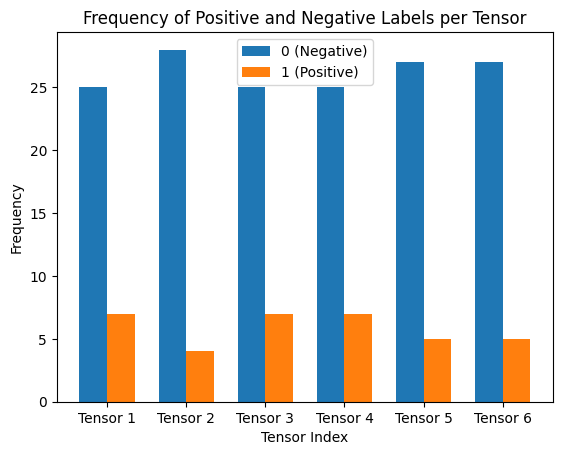

In [7]:
sample_labels = []
for i, data in enumerate(dataloader):
    # print(f"Batch {i}: Labels - {data[1]}")
    sample_labels.append(data[1])
    if i == 5:  # Check first 5 batches
        break

positives = [torch.sum(tensor == 1).item() for tensor in sample_labels]
negatives = [torch.sum(tensor == 0).item() for tensor in sample_labels]

n_tensors = len(sample_labels)
index = np.arange(n_tensors)
bar_width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(index, negatives, bar_width, label='0 (Negative)')
bar2 = ax.bar(index + bar_width, positives, bar_width, label='1 (Positive)')

ax.set_xlabel('Tensor Index')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Positive and Negative Labels per Tensor')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'Tensor {i+1}' for i in range(n_tensors)])
ax.legend()

plt.show()

# Image Classificaiton 

## Import a ResNet50 model and train it on our images with the category object centered.

### First, check if GPU is available and move the model to GPU if it is

In [ ]:
model_res50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_res50.fc.in_features
print(num_ftrs)
model_res50.fc = nn.Linear(num_ftrs, 2) # Modify the last layer for binary classification

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_res50 = model_res50.to(device)

## Train

In [48]:
input_images_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Image_Classification\train_cropped_images\224"
target_category_name = "pedestrian"
required_imgage_size = 224
dataset = Lyft_image_classification_CustomDataset(input_images_path, target_category_name, required_imgage_size)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [51]:
for input, label in dataloader:
    print(input)
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [53]:
def train_resnet50_classification(model_instance, num_epochs, batch_size, input_images_path, out_results_path, required_imgage_size=224, target_category_name="pedestrian",
                                  criterion=nn.CrossEntropyLoss(), learning_rate = 0.001, save_per_epoch=False):
    """
    Currently not implementing flexibility for choice of optimizer. Will update in future release. 
    """
    optimizer = Adam(model_instance.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        #Set training mode at beginning of each epoch in case we train on validation data within epoch with requires model.eval()
        model_instance.train()

        #Creat instances of our custom Dataset and subsequent default Dataloader
        dataset = Lyft_image_classification_CustomDataset(input_images_path, target_category_name, required_imgage_size)
        batch_size = batch_size
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        print(f"total number of batches to anticipate for epoch {epoch}: ", len(dataset)/batch_size)

        running_loss = 0.0
        running_corrects = 0
        running_true_positives = 0
        running_false_positives = 0
        running_false_negatives = 0

        # Iterate over data by batch
        # We only need inputs and labels for training. The third placeholder is for filepaths to go back and address the images that created incorrect predictions during validation/inference.
        for inputs, labels, _ in dataloader:
            #Make sure input data and labels are on the GPU device.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model_res50(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            # Assuming that loss.item() is the average loss of the predictions in the batch. Multiply by batch size to get the total loss (mean(loss)*batch_size).
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            # Calculate True Positives, False Positives, False Negatives
            for i in range(len(labels)):
                if preds[i] == labels[i] == 1:  # True Positive
                    running_true_positives += 1
                elif preds[i] == 1 and labels[i] == 0:  # False Positive
                    running_false_positives += 1
                elif preds[i] == 0 and labels[i] == 1:  # False Negative
                    running_false_negatives += 1

        epoch_loss = running_loss / len(dataset)
        epoch_acc = running_corrects.double() / len(dataset)
        # Calculate Precision, Recall, and F1 Score after the loop
        precision = running_true_positives / (running_true_positives + running_false_positives) if (running_true_positives + running_false_positives) > 0 else 0
        recall = running_true_positives / (running_true_positives + running_false_negatives) if (running_true_positives + running_false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1_score:.4f} Acc: {epoch_acc:.4f}')

        if save_per_epoch:
            # We save out the model within each epoch. This is to retain completed work if the training loop fails at some point during execution.]
            # Note: We refer to our metrics as "final" in case we don't finish all epochs, but they can be interpreted as "running" until the last epoch is complete.
            # Save the model state and metrics in a dictionary
            checkpoint = {
                'model_state_dict': model_instance.state_dict(),
                'final_loss': epoch_loss,
                'final_accuracy': epoch_acc,
                'final_precision': precision,
                'final_recall': recall,
                'final_F1': f1_score
            }

            # Save the checkpoint
            # It is Pytorch convention to save checkpoints of model states as '.pth' which is short of 'Pytorch'. This uses Python pickle module to serialize the data.
            model_checkpoint_name = f'model_res50_epoch_{epoch}_batchsize_{batch_size}_lr_{learning_rate}.pth'
            model_outpath = os.path.join(out_results_path, model_checkpoint_name)
            torch.save(checkpoint, model_outpath)
    
    if save_per_epoch == False:
        # All epochs have been completed. Save the model state and metrics in a dictionary
        checkpoint = {
            'model_state_dict': model_instance.state_dict(),
            'final_loss': epoch_loss,
            'final_accuracy': epoch_acc,
            'final_precision': precision,
            'final_recall': recall,
            'final_F1': f1_score
        }

        # Save the checkpoint
        # It is Pytorch convention to save checkpoints of model states as '.pth' which is short of 'Pytorch'. This uses Python pickle module to serialize the data.
        model_checkpoint_name = f'model_res50_batchsize_{batch_size}_lr_{learning_rate}.pth'
        model_outpath = os.path.join(out_results_path, model_checkpoint_name)
        torch.save(checkpoint, model_outpath)


In [15]:
batch_sizes = [50, 32, 10]
learning_rates = [0.001, 0.01, 0.0001]
input_images_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Image_Classification\train_cropped_images\224"
out_results_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models"
#At this point, we should already have images sized to required_image_size from the preprocessing phase. This is just to navigate to the correct image dir.
#It should also, therefore, correspond to the sized depicted by 'input_images_path'.
required_image_size = 224
target_category_name = "pedestrian"

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        train_resnet50_classification(model_instance=model_res50, num_epochs=10, batch_size=batch_size, input_images_path=input_images_path, out_results_path=out_results_path,
                                       required_imgage_size=required_image_size, target_category_name=target_category_name, learning_rate=learning_rate, save_per_epoch=True)

total number of batches to anticipate for epoch 0:  484.18
Epoch 0/9 Loss: 0.1270 Precision: 0.8549 Recall: 0.8534 F1 Score: 0.8541 Acc: 0.9508
total number of batches to anticipate for epoch 1:  484.18
Epoch 1/9 Loss: 0.0930 Precision: 0.8954 Recall: 0.9004 F1 Score: 0.8979 Acc: 0.9654
total number of batches to anticipate for epoch 2:  484.18
Epoch 2/9 Loss: 0.0743 Precision: 0.9179 Recall: 0.9190 F1 Score: 0.9184 Acc: 0.9724
total number of batches to anticipate for epoch 3:  484.18
Epoch 3/9 Loss: 0.0609 Precision: 0.9304 Recall: 0.9418 F1 Score: 0.9360 Acc: 0.9783
total number of batches to anticipate for epoch 4:  484.18
Epoch 4/9 Loss: 0.0545 Precision: 0.9367 Recall: 0.9484 F1 Score: 0.9425 Acc: 0.9805
total number of batches to anticipate for epoch 5:  484.18
Epoch 5/9 Loss: 0.0488 Precision: 0.9435 Recall: 0.9518 F1 Score: 0.9476 Acc: 0.9822
total number of batches to anticipate for epoch 6:  484.18
Epoch 6/9 Loss: 0.0427 Precision: 0.9489 Recall: 0.9584 F1 Score: 0.9536 Acc:

## Train Results

### Load all of the trained models back in and stich their results together into a summary df.

#### WARNING: The cell below will overwrite "all_model_results.csv" if you have alreayd created it.

In [10]:
# To load the model and metrics later
model_metrics = ['final_loss', 'final_accuracy', 'final_precision', 'final_recall', 'final_F1']
model_dir = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models"

all_model_results = []
for path in os.listdir(model_dir):
        model_results = {}
        model_path = os.path.join(model_dir, path)
        if model_path.endswith("pth"):
            checkpoint = torch.load(model_path)
            matches = re.search(r'epoch_(\d+)_batchsize_(\d+)_lr_([\d.]+)', model_path)
            if matches:
                model_results["model_id_path"] = path
                epoch = matches.group(1)
                model_results["epoch"] = epoch
                batch_size = matches.group(2)
                model_results["batch_size"] = batch_size
                lr = matches.group(3)
                model_results["learning_rate"] = lr

            for metric in model_metrics:
                model_results[metric] = checkpoint[metric]
            
            all_model_results.append(model_results)

all_model_results_df = pd.DataFrame(all_model_results)
all_model_results_df = all_model_results_df.sort_values(["batch_size", "learning_rate", "epoch"])

#we only need to fix final_accuracy for now until we run training again. Fix this before running training again. 
all_model_results_df["final_accuracy"] = all_model_results_df["final_accuracy"].apply(lambda x: x.item())

#Create empty columns for the validation loop to populate
all_model_results_df["validation_loss"] = None
all_model_results_df["validation_accuracy"] = None
all_model_results_df["validation_precision"] = None
all_model_results_df["validation_recall"] = None
all_model_results_df["validation_F1"] = None
all_model_results_df["false_positive_images"] = None
all_model_results_df["false_negative_images"] = None
all_model_results_df['false_positive_images'] = all_model_results_df['false_positive_images'].astype('object')
all_model_results_df['false_positive_images'] = all_model_results_df['false_positive_images'].astype('object')


#Write all_model_results_df to disk
all_model_results_df.to_csv(os.path.join(model_dir, "all_model_results.csv"))

final_epoch_results = all_model_results_df[all_model_results_df["epoch"] == "9"]
final_epoch_results

,model_id_path,epoch,batch_size,learning_rate,final_loss,final_accuracy,final_precision,final_recall,final_F1,validation_loss,validation_accuracy,validation_precision,validation_recall,validation_F1,false_positive_images,false_negative_images
81,model_res50_epoch_9_batchsize_10_lr_0.0001.pth,9,10,0.0001.,0.008955,0.997315,0.990965,0.993147,0.992055,None,None,None,None,None,None,None
82,model_res50_epoch_9_batchsize_10_lr_0.001.pth,9,10,0.001.,0.005681,0.998224,0.995102,0.994371,0.994736,None,None,None,None,None,None,None
83,model_res50_epoch_9_batchsize_10_lr_0.01.pth,9,10,0.01.,0.033554,0.987236,0.958931,0.965737,0.962322,None,None,None,None,None,None,None
84,model_res50_epoch_9_batchsize_32_lr_0.0001.pth,9,32,0.0001.,0.016930,0.994217,0.980985,0.984826,0.982902,None,None,None,None,None,None,None
85,model_res50_epoch_9_batchsize_32_lr_0.001.pth,9,32,0.001.,0.012222,0.995415,0.986774,0.986050,0.986412,None,None,None,None,None,None,None
86,model_res50_epoch_9_batchsize_32_lr_0.01.pth,9,32,0.01.,0.043471,0.984386,0.947826,0.960352,0.954048,None,None,None,None,None,None,None
87,model_res50_epoch_9_batchsize_50_lr_0.0001.pth,9,50,0.0001.,0.035888,0.986575,0.953242,0.967939,0.960534,None,None,None,None,None,None,None
88,model_res50_epoch_9_batchsize_50_lr_0.001.pth,9,50,0.001.,0.029320,0.989219,0.964763,0.971610,0.968175,None,None,None,None,None,None,None
89,model_res50_epoch_9_batchsize_50_lr_0.01.pth,9,50,0.01.,0.068964,0.974514,0.915648,0.935144,0.925294,None,None,None,None,None,None,None


# Validation/Inference

In [ ]:
# Perform only if validation images have not yet been resized for uniform size for model input.
# validation_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\validation_cropped_images\224'
# sizes = [224]
# dynamic_transform(validation_images_dir, sizes)

In [11]:
def validate_resnet50_classification(model_checkpoint, model_name_id, validation_images_dir, training_records_df_path, required_imgage_size=224, target_category_name="pedestrian",
                                  criterion=nn.CrossEntropyLoss()):
    """
    We assume training has already occured and that the training model and results exist in an anticipated form 'training_records_df' which validation output will be written to.
    """

    training_records_df = pd.read_csv(training_records_df_path).drop(columns=['Unnamed: 0'], errors='ignore')
    #Create a fresh model instance and then import its state from the model_checkpoint.
    model_res50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    num_ftrs = model_res50.fc.in_features
    # Modify the last layer for binary classification. This is because this was the architecture which was used for the training model.
    model_res50.fc = nn.Linear(num_ftrs, 2)

    #Load the state into the model instance.
    model_res50.load_state_dict(model_checkpoint['model_state_dict'])
    # Move model to device and set the model to evaluation mode
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_res50.to(device)
    model_res50.eval()

    #Creat instances of our custom Dataset and subsequent default Dataloader
    dataset = Lyft_image_classification_CustomDataset(validation_images_dir, target_category_name, required_imgage_size)
    row_index = training_records_df[training_records_df["model_id_path"] == model_name_id].index
    batch_size = int(training_records_df.loc[row_index, "batch_size"].iloc[0])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Initialize metrics
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    running_true_positives = 0
    running_false_positives = 0
    running_false_negatives = 0

    #Holders for the incorrect prediction image paths.
    false_positive_images = []
    false_negative_images = []

    # Disable gradient calculations as they are not needed for validation
    with torch.no_grad():
        for inputs, labels, image_names in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_res50(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            # Calculate True Positives, False Positives, False Negatives
            for i in range(len(labels)):
                if preds[i] == labels[i] == 1:  # True Positive
                    running_true_positives += 1
                elif preds[i] == 1 and labels[i] == 0:  # False Positive
                    running_false_positives += 1
                    false_positive_images.append(image_names[i])
                elif preds[i] == 0 and labels[i] == 1:  # False Negative
                    running_false_negatives += 1
                    false_negative_images.append(image_names[i])


    # Calculate the average loss and accuracy over the validation set
    val_loss = running_loss / total_samples
    val_acc = running_corrects.double() / total_samples
    val_acc = val_acc.item()
    # Calculate Precision, Recall, and F1 Score after the loop
    precision = running_true_positives / (running_true_positives + running_false_positives) if (running_true_positives + running_false_positives) > 0 else 0
    recall = running_true_positives / (running_true_positives + running_false_negatives) if (running_true_positives + running_false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'Validation Loss: {val_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1_score:.4f} Acc: {val_acc:.4f}')

    #Write the validation output to the corresponding row/col of training_records_df
    # Reminder: training_records_df[condition]["column"] = value can lead to a SettingWithCopyWarning in pandas.
    # Find the row index, and use .loc[] instead.
    row_index = training_records_df[training_records_df["model_id_path"] == model_name_id].index
    training_records_df.loc[row_index, "validation_loss"] = val_loss
    training_records_df.loc[row_index, "validation_accuracy"] = val_acc
    training_records_df.loc[row_index, "validation_precision"] = precision
    training_records_df.loc[row_index, "validation_recall"] = recall
    training_records_df.loc[row_index, "validation_F1"] = f1_score
    
    false_positive_images_str = str(false_positive_images)
    false_negative_images_str = str(false_negative_images)
    training_records_df.loc[row_index, "false_positive_images"] = false_positive_images_str
    training_records_df.loc[row_index, "false_negative_images"] = false_negative_images_str

    training_records_df.to_csv(training_records_df_path, index=False)


In [12]:
models_to_validate = list(final_epoch_results["model_id_path"].values)
model_dir = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models"
validation_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Image_Classification\validation_cropped_images\224'
training_records_df_path = os.path.join(model_dir, "all_model_results.csv")
required_imgage_size = 224
target_category_name = "pedestrian"

In [16]:
for model_name in models_to_validate:
    print(model_name)
    checkpoint = torch.load(os.path.join(model_dir, model_name))
    validate_resnet50_classification(checkpoint, model_name, validation_images_dir, training_records_df_path, required_imgage_size, target_category_name)

model_res50_epoch_9_batchsize_10_lr_0.0001.pth
Validation Loss: 0.0913 Precision: 0.8669 Recall: 0.9303 F1 Score: 0.8975 Acc: 0.9726
model_res50_epoch_9_batchsize_10_lr_0.001.pth


C:\Users\stern\AppData\Local\Temp\ipykernel_16028\984681418.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['cropped_host-a102_cam5_1242754969332234006_1a94c607332752ad75c4373a2693f72db74598dd75b43451c39df6b36e0c075c', 'cropped_host-a011_cam6_1232909963751145006_705606be0a788cd9d491abbe223d9d0d55e8d37d2dd279952c4df6ac75d84f06', 'cropped_host-a011_cam6_1236104044351145006_af9b9351c5e4d7a68e996a00d654e4dd6ae83e8501f5a4879d73c6b5c61c2e49', 'cropped_host-a004_cam6_1233685245950948006_c1a43ebea3fcde204c70598d6ef1ca4a57f710aea9034965a23480099112f3fb', 'cropped_host-a102_cam3_1241548688100000006_073638355e80d50eefe47d143249b41fa6727f34320b6600bd33e7d90d52e31f', 'cropped_host-a101_cam0_1242144896850000006_3b2a982df97488a1685300692824727ca823b9d6a38a9579917d849e52e2fdd3', 'cropped_host-a011_cam6_1233688944551145006_cbd96872c2f59fe53d0f580c3b00b6bdba9df1afee166003808b7b94d83858f0', 'cropped_host-a101_cam6_1240875144450

Validation Loss: 0.1591 Precision: 0.8004 Recall: 0.9500 F1 Score: 0.8688 Acc: 0.9630
model_res50_epoch_9_batchsize_10_lr_0.01.pth
Validation Loss: 0.0892 Precision: 0.8635 Recall: 0.9152 F1 Score: 0.8886 Acc: 0.9704
model_res50_epoch_9_batchsize_32_lr_0.0001.pth
Validation Loss: 0.0916 Precision: 0.8414 Recall: 0.9423 F1 Score: 0.8890 Acc: 0.9696
model_res50_epoch_9_batchsize_32_lr_0.001.pth
Validation Loss: 0.1620 Precision: 0.7954 Recall: 0.9415 F1 Score: 0.8623 Acc: 0.9612
model_res50_epoch_9_batchsize_32_lr_0.01.pth
Validation Loss: 0.0750 Precision: 0.8624 Recall: 0.9226 F1 Score: 0.8915 Acc: 0.9710
model_res50_epoch_9_batchsize_50_lr_0.0001.pth
Validation Loss: 0.0805 Precision: 0.8612 Recall: 0.9300 F1 Score: 0.8943 Acc: 0.9716
model_res50_epoch_9_batchsize_50_lr_0.001.pth
Validation Loss: 0.0896 Precision: 0.8472 Recall: 0.9470 F1 Score: 0.8943 Acc: 0.9711
model_res50_epoch_9_batchsize_50_lr_0.01.pth
Validation Loss: 0.1148 Precision: 0.7597 Recall: 0.9646 F1 Score: 0.8500 Acc

## Visualize the performance metrics either for training or validation

In [25]:
validation_results_df = pd.read_csv(training_records_df_path).drop(columns=['Unnamed: 0'], errors='ignore')
validation_results_df = validation_results_df[validation_results_df["epoch"] == 9]
# Convert string representations to actual lists
validation_results_df['false_positive_images'] = validation_results_df['false_positive_images'].apply(ast.literal_eval)
validation_results_df['false_negative_images'] = validation_results_df['false_negative_images'].apply(ast.literal_eval)
validation_results_df

,model_id_path,epoch,batch_size,learning_rate,final_loss,final_accuracy,final_precision,final_recall,final_F1,validation_loss,validation_accuracy,validation_precision,validation_recall,validation_F1,false_positive_images,false_negative_images
9,model_res50_epoch_9_batchsize_10_lr_0.0001.pth,9,10,0.0001.,0.008955,0.997315,0.990965,0.993147,0.992055,0.091312,0.972572,0.866940,0.930258,0.897483,[cropped_host-a102_cam5_1242754969332234006_1a...,[cropped_host-a011_cam2_1233688946717605006_b4...
19,model_res50_epoch_9_batchsize_10_lr_0.001.pth,9,10,0.001.,0.005681,0.998224,0.995102,0.994371,0.994736,0.159119,0.962968,0.800370,0.950027,0.868801,[cropped_host-a007_cam3_1231093059199360006_50...,[cropped_host-a011_cam0_1232752780051142006_d3...
29,model_res50_epoch_9_batchsize_10_lr_0.01.pth,9,10,0.01.,0.033554,0.987236,0.958931,0.965737,0.962322,0.089225,0.970375,0.863472,0.915157,0.888563,[cropped_host-a101_cam1_1242748999766305006_67...,[cropped_host-a011_cam0_1232752781651142006_aa...
39,model_res50_epoch_9_batchsize_32_lr_0.0001.pth,9,32,0.0001.,0.016930,0.994217,0.980985,0.984826,0.982902,0.091628,0.969630,0.841383,0.942339,0.889004,[cropped_host-a101_cam6_1240875137450000006_97...,[cropped_host-a101_cam6_1240875138650000006_7e...
49,model_res50_epoch_9_batchsize_32_lr_0.001.pth,9,32,0.001.,0.012222,0.995415,0.986774,0.986050,0.986412,0.162003,0.961196,0.795407,0.941516,0.862316,[cropped_host-a101_cam6_1240875147050000006_2a...,[cropped_host-a004_cam0_1232923267651064006_d5...
59,model_res50_epoch_9_batchsize_32_lr_0.01.pth,9,32,0.01.,0.043471,0.984386,0.947826,0.960352,0.954048,0.074976,0.971012,0.862423,0.922570,0.891483,[cropped_host-a101_cam4_1240875154416660006_b5...,[cropped_host-a004_cam1_1235947105534300006_e4...
69,model_res50_epoch_9_batchsize_50_lr_0.0001.pth,9,50,0.0001.,0.035888,0.986575,0.953242,0.967939,0.960534,0.080530,0.971615,0.861175,0.929984,0.894257,[cropped_host-a101_cam6_1240875137450000006_97...,[cropped_host-a011_cam3_1236104051500995006_15...
79,model_res50_epoch_9_batchsize_50_lr_0.001.pth,9,50,0.001.,0.029320,0.989219,0.964763,0.971610,0.968175,0.089566,0.971119,0.847212,0.947007,0.894334,[cropped_host-a102_cam3_1242754977999260006_d1...,[cropped_host-a011_cam5_1232752550067719006_71...
89,model_res50_epoch_9_batchsize_50_lr_0.01.pth,9,50,0.01.,0.068964,0.974514,0.915648,0.935144,0.925294,0.114841,0.956058,0.759732,0.964580,0.849988,[cropped_host-a101_cam2_1242749002782945006_6c...,[cropped_host-a101_cam0_1242748836349526006_2d...


### F1 Score heatmap

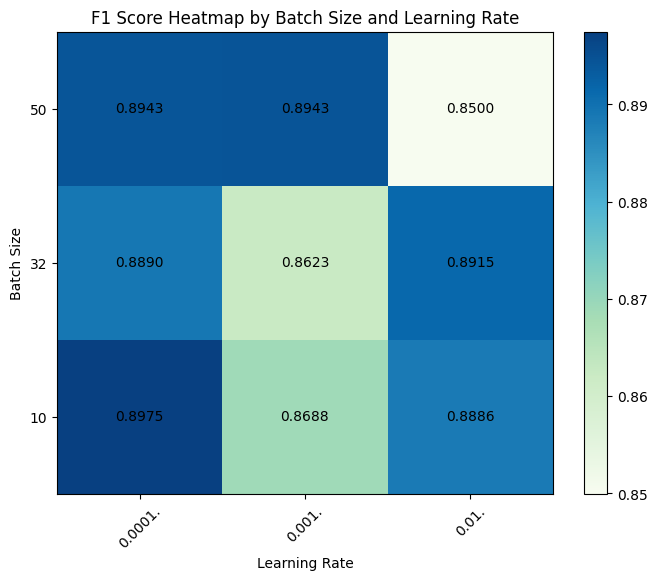

In [18]:
# Pivot the DataFrame to create a grid
pivot_df = validation_results_df.pivot(index='batch_size', columns='learning_rate', values='validation_F1')

# Creating the heatmap
plt.figure(figsize=(8, 6))
# Using numpy to create an array of the pivot data
data_array = pivot_df.to_numpy()

# The columns and rows to display
col_labels = pivot_df.columns.values
row_labels = pivot_df.index.values

# Creating the plot
c = plt.pcolormesh(data_array, cmap='GnBu', shading='auto')

# Adding color bar
plt.colorbar(c)

# Adding titles and labels
plt.title('F1 Score Heatmap by Batch Size and Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')

# Adjusting the ticks to be at the center of each cell
plt.xticks(np.arange(0.5, len(col_labels), 1), col_labels, rotation=45)
plt.yticks(np.arange(0.5, len(row_labels), 1), row_labels)

# Add text annotations
for (i, j), val in np.ndenumerate(data_array):
    plt.text(j + 0.5, i + 0.5, f"{val:.4f}", ha='center', va='center', color='black')

# Show plot
plt.show()

In [26]:
false_positive_images = [img for sublist in validation_results_df["false_positive_images"] for img in sublist]
false_positive_counts = Counter(false_positive_images)

false_negative_images = [img for sublist in validation_results_df["false_negative_images"] for img in sublist]
false_negative_counts = Counter(false_negative_images)


In [30]:
for image_name, image_count in false_positive_counts.items():
    print(image_name, image_count)
    break

cropped_host-a102_cam5_1242754969332234006_1a94c607332752ad75c4373a2693f72db74598dd75b43451c39df6b36e0c075c 9


In [56]:
base_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Image_Classification\validation_cropped_images\224"

def false_positive_finder(base_path, false_positive_counts):
    category_counts = {}
    for image_name, image_count in false_positive_counts.items():
    # Iterate over the subdirectories in the base path
        for subdir in os.listdir(base_path):
            subdir_path = os.path.join(base_path, subdir)
            
            # Check if the path is a directory
            if os.path.isdir(subdir_path):
                # Construct the potential full path of the file
                potential_file_path = os.path.join(subdir_path, image_name + ".jpeg")
                # Check if the file exists at this path
                if os.path.isfile(potential_file_path):
                    match = re.search(r'validation_cropped_images\\(\d+)\\([^\\]+)\\', potential_file_path)
                    if match:
                        category_name = match.group(2)
                        if category_name in category_counts.keys():
                            category_counts[category_name] +=1
                        else:
                            category_counts[category_name] = 1
            else:
                print("File not found in the immediate subdirectories.")

    category_counts_df = pd.DataFrame.from_dict(category_counts, orient="index", columns=['Count'])
    category_counts_df = category_counts_df.reset_index().rename(columns={'index': 'Category'}).sort_values("Count", ascending=False)
    return category_counts_df

test_false_pos_classes = false_positive_finder(base_path, false_positive_counts)


In [57]:
test_false_pos_classes

,Category,Count
3,bicycle,882
1,truck,342
0,other_vehicle,249
2,bus,155
5,emergency,16
4,motorcycle,10


In [58]:
# Create the bar chart
fig_false_positives = px.bar(test_false_pos_classes, x='Category', y='Count', title="False positive categories incorrectly classified as Pedestrian", log_y=True)

# Show the plot
fig_false_positives.show()

KeyError: 'model_id'

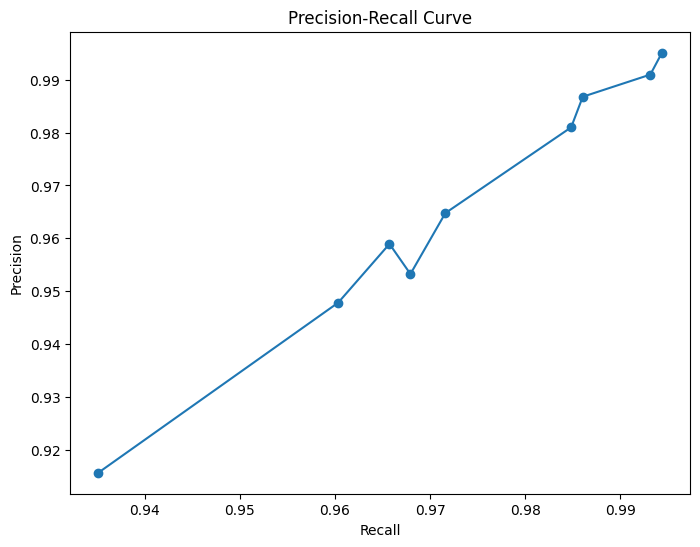

In [10]:
final_epoch_results_sorted = final_epoch_results.sort_values(by='final_recall')

# Plotting Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(final_epoch_results_sorted['final_recall'], final_epoch_results_sorted['final_precision'], marker='o')

# Labeling the plot
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Optionally add model_id as text labels
for i, row in final_epoch_results_sorted.iterrows():
    plt.text(row['final_recall'], row['final_precision'], str(row['model_id']))

# Show the plot
plt.show()

In [16]:
# model_res50.load_state_dict(checkpoint['model_state_dict'])
model_res50 = torch.load(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\resnet50_2023_11_21_22_15")
model_res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Visualize the output of the first layer which is a convolution layer with kernel 7x7. This is just to remind us what we are dealing with.

tensor([[[0.4760, 0.4743, 0.4661, 0.4955, 0.5031, 0.4722, 0.4078],
         [0.4549, 0.4583, 0.4736, 0.5090, 0.5175, 0.4930, 0.4511],
         [0.4549, 0.4578, 0.4556, 0.5131, 0.5559, 0.5352, 0.5052],
         [0.4458, 0.4449, 0.4122, 0.4309, 0.4550, 0.4880, 0.4916],
         [0.4411, 0.4677, 0.4452, 0.4304, 0.3853, 0.4004, 0.4419],
         [0.4417, 0.4869, 0.4927, 0.5223, 0.4753, 0.4100, 0.4144],
         [0.4181, 0.4639, 0.4738, 0.5290, 0.5222, 0.4761, 0.4490]],

        [[0.4667, 0.4824, 0.4985, 0.5539, 0.5650, 0.5308, 0.4546],
         [0.4587, 0.4801, 0.5151, 0.5860, 0.6175, 0.5998, 0.5558],
         [0.4292, 0.4116, 0.4039, 0.4862, 0.5737, 0.6037, 0.5906],
         [0.4195, 0.3754, 0.2920, 0.2714, 0.3157, 0.4213, 0.4813],
         [0.4701, 0.4662, 0.4027, 0.3180, 0.2336, 0.2634, 0.3562],
         [0.4962, 0.5463, 0.5501, 0.5535, 0.4620, 0.3612, 0.3520],
         [0.4673, 0.5338, 0.5726, 0.6424, 0.6185, 0.5381, 0.4710]],

        [[0.4642, 0.4702, 0.4877, 0.5323, 0.5415, 0.5142, 

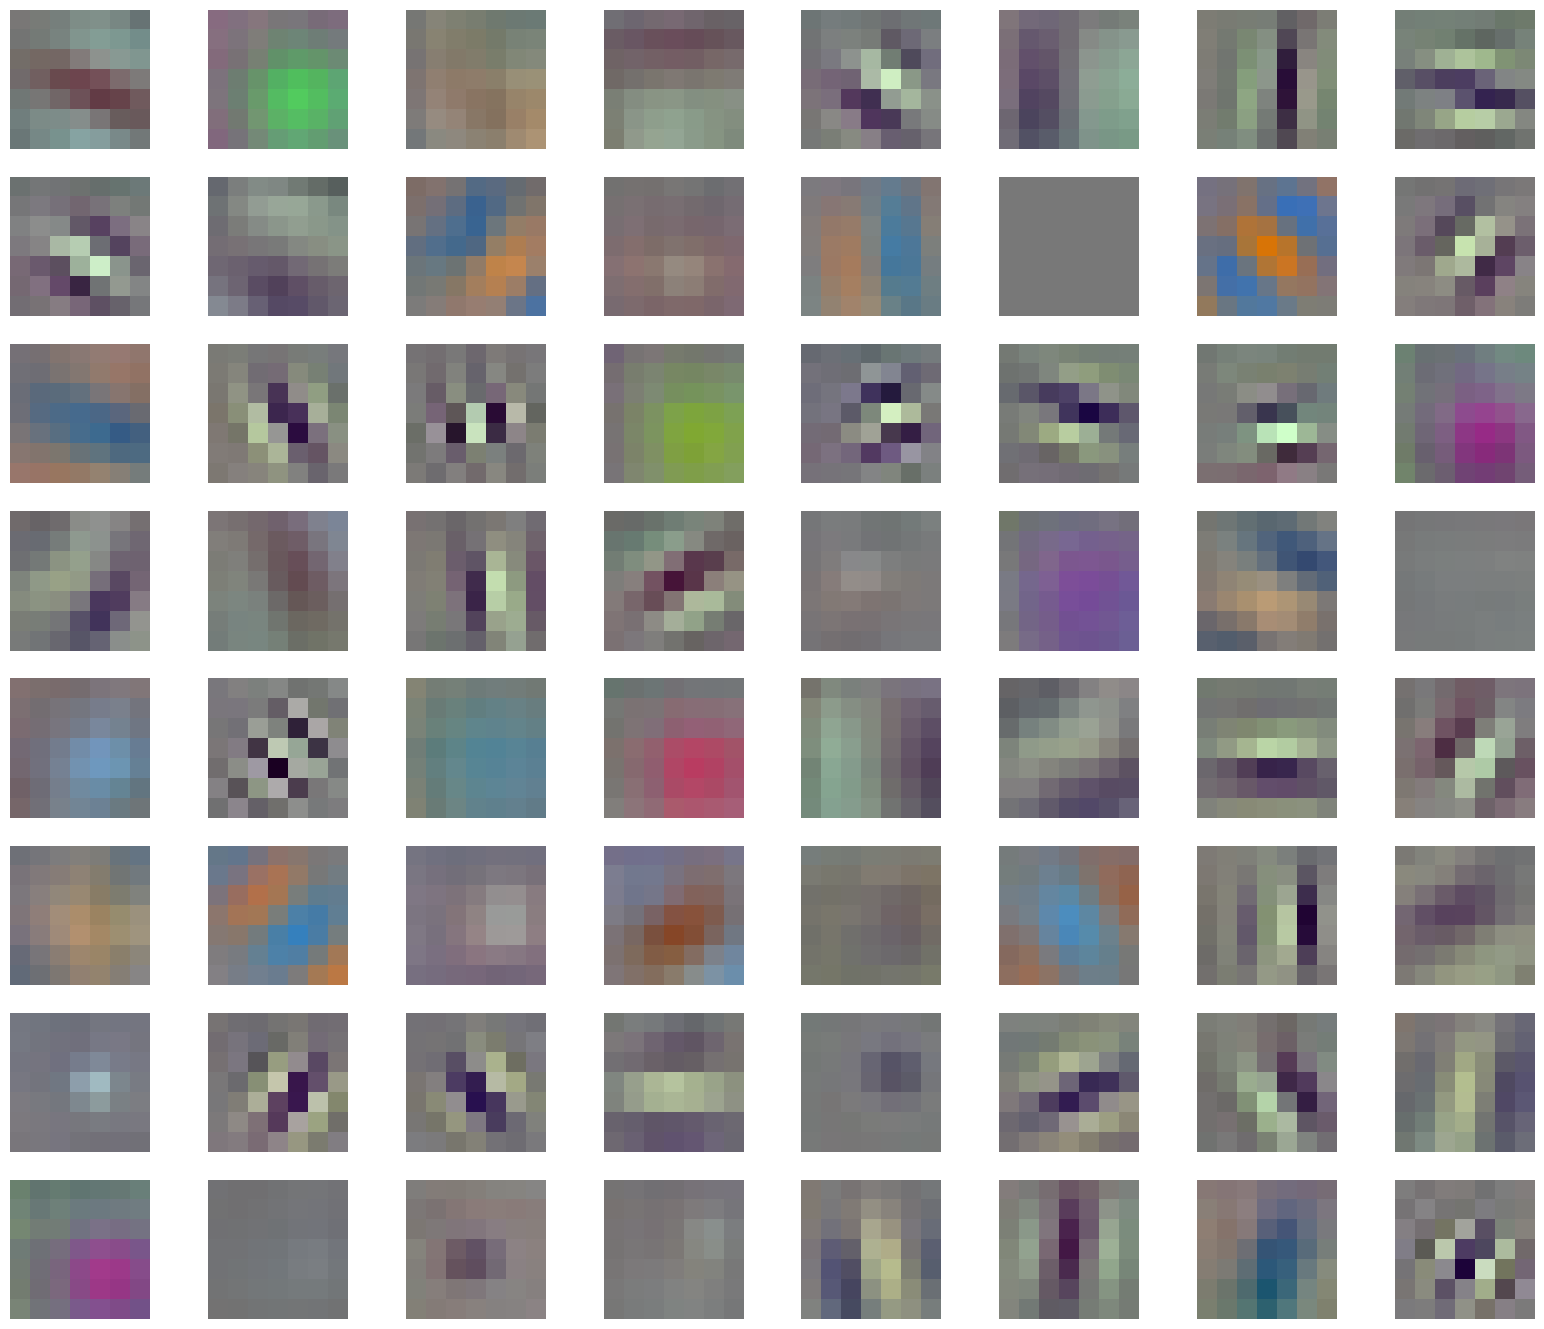

In [103]:
# Ensure it's in evaluation mode for visualization
model_res50.eval()  # This changes the model to evaluation mode

# Get the weights of the first convolutional layer
weights = model_res50.conv1.weight.data.cpu()

# Normalize the weights for better visualization
weights = (weights - weights.min()) / (weights.max() - weights.min())
print(weights[0])
print(weights[0].permute(1, 2, 0))
# Plot the first few filters
plt.figure(figsize=(20, 17))
for i in range(64):  # Let's visualize 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(weights[i].permute(1, 2, 0))  # Rearrange the dimensions
    plt.axis('off')
plt.show()

In [109]:
# sizes = [224]
# dynamic_transform(validation_images_dir, sizes)

In [111]:
checkpoint = {
    'model_state_dict': model_res50.state_dict(),
    'validation_loss': val_loss,
    'validation_accuracy': val_acc
}

# Save the checkpoint
torch.save(checkpoint, 'model_res50_validation_checkpoint.pth')

### Validation/Inference Results

# Object Detection

### Heatmap. Note: We use both training and validation data to aggregate a heat map. The heat map itelf isn't involved as a parameter in the model. This is simply just using a greater sample size to determine the places within the full sized images that are most and least likely for pedestrians to occur. This way, we can decrease the image space that our model will scan for each image.

In [4]:
train_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\train_logs_tokens_pedestrian.json"
val_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\validation_logs_tokens_pedestrian.json"
with open(train_path, 'r') as file:
    train_pedestrians = json.load(file)
with open(val_path, 'r') as file:
    val_pedestrians = json.load(file)

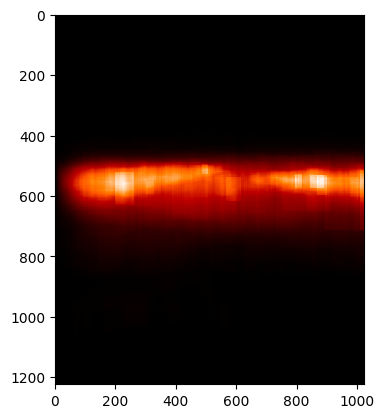

In [26]:
# Initialize heatmap grid
heatmap = np.zeros((1224, 1024))

for filename, coords in train_pedestrians.items():
    
    box_coords = coords[0]
    
    # Calculate bounding box coordinates and round to nearest integer
    x_min = int(np.round(np.min(box_coords[0])))
    y_min = int(np.round(np.min(box_coords[1])))
    x_max = int(np.round(np.max(box_coords[0])))
    y_max = int(np.round(np.max(box_coords[1])))

    # Adjust if the coordinates are outside the image
    x_min = max(x_min, 0)
    y_min = max(y_min, 0)
    x_max = min(x_max, heatmap.shape[1] - 1)
    y_max = min(y_max, heatmap.shape[0] - 1)

    heatmap[y_min:y_max, x_min:x_max] += 1

for filename, coords in val_pedestrians.items():

    box_coords = coords[0]

    # Calculate bounding box coordinates and round to nearest integer
    x_min = int(np.round(np.min(box_coords[0])))
    y_min = int(np.round(np.min(box_coords[1])))
    x_max = int(np.round(np.max(box_coords[0])))
    y_max = int(np.round(np.max(box_coords[1])))

    # Adjust if the coordinates are outside the image
    x_min = max(x_min, 0)
    y_min = max(y_min, 0)
    x_max = min(x_max, heatmap.shape[1] - 1)
    y_max = min(y_max, heatmap.shape[0] - 1)

    heatmap[y_min:y_max, x_min:x_max] += 1

# Normalize the heatmap
heatmap = heatmap / np.max(heatmap)

# Plot the heatmap
plt.imshow(heatmap, cmap='gist_heat', interpolation='nearest')
plt.show()

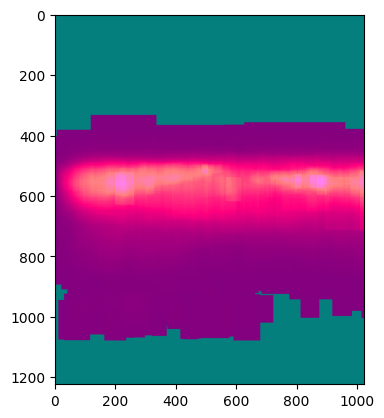

In [27]:
# Create a mask for any non-zero values
outlier_mask = heatmap > 0

# Plot the heatmap with non-zero values highlighted
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.imshow(outlier_mask, cmap='cool', alpha=0.5) # overlaying with a different color
plt.show()

## Import FasterRCNN model.

In [5]:
# Load a pre-trained fasterrcnn_mobilenet_v3_large_fpn model
model_fastercnn = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier with a new one for binary classification (background + pedestrian)
num_classes = 2  # 1 class (pedestrian) + background
# Get the number of input features for the classifier
in_features = model_fastercnn.roi_heads.box_predictor.cls_score.in_features
# Replace the pre-trained head with a new one (note: this automatically changes the anchor generator to match the backbone)
model_fastercnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_fastercnn = model_fastercnn.to(device)

cuda:0


## Create our Dataset and Dataloader objects for object detection

In [8]:
def collate_fn(batch):
    """
    Custom collate function for handling varying sizes of bounding boxes and labels.
    """
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.tensor([]), {}

    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    images = default_collate(images)  # Stack images as they should have the same size
    # Do not stack targets as they can have varying sizes
    return images, targets

images_base_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images"
train_data_dict_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\train_merged.json'
with open(train_data_dict_path, "r") as file:
    train_data_dict = json.load(file)
dataset_training_detection = Lyft_binary_object_detection_CustomDataset(train_data_dict, images_base_path=images_base_path, transform=None, random_sample=None, positive_imgs_only=True)
# Use the custom collate function in the DataLoader
batch_size=10
dataloader_training_detection = DataLoader(dataset_training_detection, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
print("total number of training batches to anticipate: ", len(dataset_training_detection)/batch_size, "Dataset total length: ", len(dataset_training_detection))

validation_data_dict_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\validation_merged.json'
with open(validation_data_dict_path, "r") as file:
    validation_data_dict = json.load(file)
dataset_validation_detection = Lyft_binary_object_detection_CustomDataset(validation_data_dict, images_base_path=images_base_path, transform=None, random_sample=None, positive_imgs_only=True)
# Use the custom collate function in the DataLoader
batch_size=10
dataloader_validation_detection = DataLoader(dataset_validation_detection, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
print("total number of validation batches to anticipate: ", len(dataset_validation_detection)/batch_size, "Dataset total length: ", len(dataset_validation_detection))
print(dataloader_validation_detection.dataset.file_names)

total number of training batches to anticipate:  331.2 Dataset total length:  3312
total number of validation batches to anticipate:  621.9 Dataset total length:  6219
dict_keys(['host-a004_cam0_1232817652451064006.jpeg', 'host-a004_cam3_1232817653800897006.jpeg', 'host-a004_cam1_1232825405634300006.jpeg', 'host-a004_cam3_1232817653600897006.jpeg', 'host-a004_cam2_1232825406817652006.jpeg', 'host-a004_cam1_1232825406034300006.jpeg', 'host-a004_cam2_1232825406417652006.jpeg', 'host-a004_cam1_1232825405834300006.jpeg', 'host-a004_cam2_1232825406617652006.jpeg', 'host-a004_cam1_1232825405434300006.jpeg', 'host-a004_cam1_1232817652634300006.jpeg', 'host-a004_cam0_1232817652251064006.jpeg', 'host-a011_cam2_1233087928217605006.jpeg', 'host-a011_cam2_1233087928017605006.jpeg', 'host-a011_cam1_1233087927834517006.jpeg', 'host-a011_cam1_1233087927434517006.jpeg', 'host-a011_cam1_1233087927634517006.jpeg', 'host-a102_cam2_1241468929483330006.jpeg', 'host-a101_cam1_1241886992566660006.jpeg', 'hos

## Train

In [13]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    box1 (list of floats): bounding box in format [x_min, y_min, x_max, y_max].
    box2 (list of floats): bounding box in format [x_min, y_min, x_max, y_max].

    Returns:
    float: IoU of box1 and box2.
    """

    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Check if there is no overlap
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate combined area
    total_area = box1_area + box2_area - intersection_area

    # Compute IoU
    iou = intersection_area / total_area

    return iou

In [14]:
validation_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup"
validation_filename = r"validation_merged.json"
validation_input_path = os.path.join(validation_path, validation_filename)
with open(validation_input_path, "r") as file:
    validation_dict = json.load(file)

# Before starting your training loop
torch.cuda.empty_cache()  # Clear cache if any

# Training loop
num_epochs = 5
iou_threshold = 0.5  # Example threshold
optimizer = torch.optim.Adam(model_fastercnn.parameters(), lr=0.001)  # Example optimizer

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time for the epoch
    model_fastercnn.train()  # Set model to training mode
    running_loss = 0.0
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    batch_i = 0

    for images, targets in dataloader_training_detection:
        batch_start_time = time.time()
        print("On batch: ", batch_i)
        batch_i += 1
        
        images = images.to(device)
        targets_on_device = []
        for target in targets:
            target_on_device = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in target.items()}
            targets_on_device.append(target_on_device)


        # Forward pass
        optimizer.zero_grad()  # Clear existing gradients
        loss_dict = model_fastercnn(images, targets_on_device)  # Forward pass
        losses = sum(loss for loss in loss_dict.values())  # Sum up all losses

        # Backward pass and optimize
        losses.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
        running_loss += losses.item()
        batch_duration = time.time() - batch_start_time  # Calculate duration for the batch
        print(f'Batch Duration: {batch_duration:.2f} seconds')

    # Evaluation mode for inference
    model_fastercnn.eval()
    inference_batch_i = 0
    with torch.no_grad():
        for images, targets in dataloader_validation_detection:
            inference_batch_start_time = time.time()
            print("On inference batch: ", inference_batch_i)
            inference_batch_i += 1
            
            images = images.to(device)
            predictions = model_fastercnn(images)
            filenames = dataloader_validation_detection.dataset.file_names
            try:
                # Update the dictionary with predictions
                for filename, target, prediction in zip(filenames, targets, predictions):
                    predicted_boxes = prediction['boxes'].cpu().numpy().tolist()
                    predicted_labels = prediction['labels'].cpu().numpy().tolist()
                    print("predicted boxex: ", predicted_boxes)
                    print("predicted labels: ", predicted_labels)

                    if "predicted_boxes" in validation_dict.keys():
                        validation_dict[filename]['predicted_boxes'].extend(predicted_boxes)
                    else:
                        validation_dict[filename]['predicted_boxes'] = predicted_boxes
                    if "predicted_labels" in validation_dict.keys():
                        validation_dict[filename]['predicted_labels'].extend(predicted_labels)
                    else:
                        validation_dict[filename]['predicted_labels'] = predicted_labels
            except Exception as e:
                print(f"An error occurred: {e}")

                
            for target, prediction in zip(targets, predictions):
                ground_truth_boxes = target["boxes"]
                predicted_boxes = prediction["boxes"]

                if len(predicted_boxes) > 0:
                    iou = calculate_iou(predicted_boxes[0], ground_truth_boxes[0])

                    if iou >= iou_threshold:
                        total_true_positives += 1
                    else:
                        total_false_positives += 1
                else:
                    total_false_negatives += 1
            
            inference_batch_duration = time.time() - inference_batch_start_time  # Calculate duration for the batch
            print(f'Inference Batch Duration: {inference_batch_duration:.2f} seconds')

    # Calculate metrics after each epoch
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    model_fastercnn.train()  # Set back to training mode

    epoch_loss = running_loss / len(dataloader_training_detection.dataset)
    epoch_duration = time.time() - epoch_start_time  # Calculate duration for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1_score:.4f}, Duration: {epoch_duration:.2f} seconds")

    #Save after each epoch.
    model_fastercnn_dict = model_fastercnn.state_dict()
    torch.save(model_fastercnn_dict, r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\model_fastercnn_12_2_23_00_00")

    #Output our resulting validation data dict with the predictions appended to it. Recall that this is the initial data dict that is read in in our dataset_training_detection.
    predictions_filename = r"validation_merged_w_predictions.json"
    predictions_output_path = os.path.join(validation_path, predictions_filename)
    with open(predictions_output_path, "w") as outfile:
        json.dump(validation_dict, outfile)

On batch:  0
Batch Duration: 29.34 seconds
On batch:  1
Batch Duration: 34.47 seconds
On batch:  2
Batch Duration: 37.97 seconds
On batch:  3
Batch Duration: 3.11 seconds
On inference batch:  0
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
Inference Batch Duration: 9.31 seconds
On inference batch:  1
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted box

KeyboardInterrupt: 

In [7]:
model_fastercnn_dict = model_fastercnn.state_dict()
torch.save(model_fastercnn_dict, r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\model_fastercnn_12_1_23_00_00")